<a href="https://colab.research.google.com/github/archie-sinha/DL-Project---Stop-and-Not-Stop-Image-Classification/blob/main/Cousera_ML_Stop_Sign_Signal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow scikit-learn


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and preprocess the datasets
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img.astype('float32') / 255.0
            images.append(img)
    return np.array(images)

In [ ]:
# Set paths to your datasets
stop_signs_folder = '/content/drive/MyDrive/Coursera Important materials/Corsera ML Project - Stop Sign Signal Detection/stop/stop'
not_stop_signs_folder  = '/content/drive/MyDrive/Coursera Important materials/Corsera ML Project - Stop Sign Signal Detection/not_stop/not_stop'

In [ ]:
stop_sign_images = load_images_from_folder(stop_signs_folder)
not_stop_sign_images = load_images_from_folder(not_stop_signs_folder)

In [ ]:
# Print the number of images
print(f"Total number of stop sign images: {len(stop_sign_images)}")
print(f"Total number of not stop sign images: {len(not_stop_sign_images)}")

Total number of stop sign images: 97
Total number of not stop sign images: 100


In [ ]:
import matplotlib.pyplot as plt

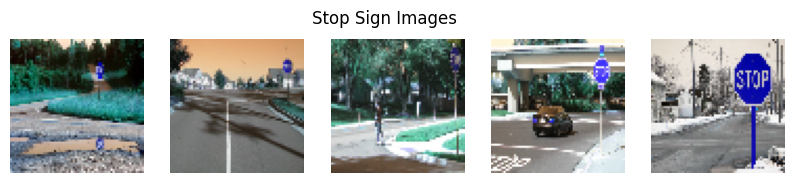

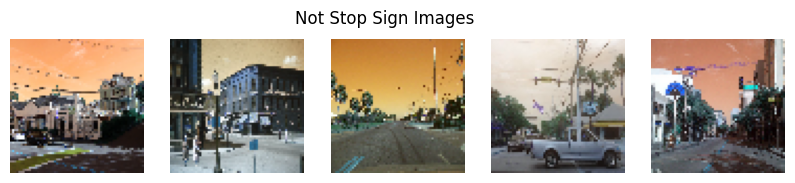

In [ ]:
# Display a few images
def display_images(images, title, num_images=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(title)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

display_images(stop_sign_images, "Stop Sign Images")
display_images(not_stop_sign_images, "Not Stop Sign Images")

In [ ]:
# Combine datasets
all_images = np.concatenate((stop_sign_images, not_stop_sign_images))

In [ ]:
# Autoencoder model
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(all_images, all_images, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
7/7 [==============================] - 8s 105ms/step - loss: 0.6825
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6592
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6376
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6227
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6105
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6041
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5952
Epoch 8/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5948
Epoch 9/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5929
Epoch 10/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5922
Epoch 11/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5893
Epoch 12/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5889
Epoch 13/50
7/7 [==============================] - 0s 11ms/s

In [ ]:
# Feature extraction
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(all_images)
encoded_images = encoded_images.reshape((encoded_images.shape[0], -1))

7/7 [==============================] - 0s 2ms/step


In [ ]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_images)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Assuming the first half of images are stop signs and the second half are not stop signs
ground_truth = np.array([0] * len(stop_sign_images) + [1] * len(not_stop_sign_images))

In [ ]:
# Check accuracy
accuracy = np.sum(labels == ground_truth) / len(ground_truth)
print(f"Clustering accuracy: {accuracy * 100:.2f}%")

Clustering accuracy: 54.31%


In [ ]:
# Function to classify new images
def classify_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    encoded_img = encoder.predict(img)
    encoded_img = encoded_img.reshape((1, -1))
    label = kmeans.predict(encoded_img)

    if label == 0:
        classification = "Stop Sign"
    else:
        classification = "Not Stop Sign"

    # Display image and classification result
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Classification: {classification}")
    plt.axis('off')
    plt.show()

    return classification



1/1 [==============================] - 0s 27ms/step


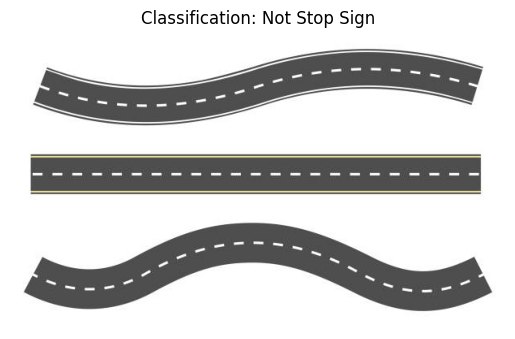

Not Stop Sign


In [ ]:
# Test the classification function
test_image_path = '/content/7_not stop sign.jpg'
print(classify_image(test_image_path))